#### GAN Mountain images


This experiment is testing for the GAN architecture generate a new landscape mountain images. 




<br>
<hr>

In [1]:
!pip install -q imageio 
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6qchkm70
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6qchkm70
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01570ea4df9a2577e180d4e55a445d114c43cdfe0_-cp36-none-any.whl size=145889 sha256=d7e7af5012d7f272985f42e586db9c0b694ae79f31f56ab61a5295d9824283c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1r73ljbt/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [2]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import glob 
from tqdm import tqdm
import time 
import PIL
import imageio
import random
from numpy.random import randn
from numpy.random import randint


from IPython import display
%matplotlib inline 
import warnings 
warnings.filterwarnings("ignore")


import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Reshape, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

In [3]:
# seed 
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# GPU 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [5]:
# images for analysis 

images_raw = []
path = "/content/drive/My Drive/Deep Learning - Projetos/GANs/imagens"

for dir in os.listdir(path):
    image_path = os.path.join(path, dir)
    img = load_img(image_path, target_size=(200, 200, 3), color_mode="rgb")
    img = array_to_img(img)
    images_raw.append(img)

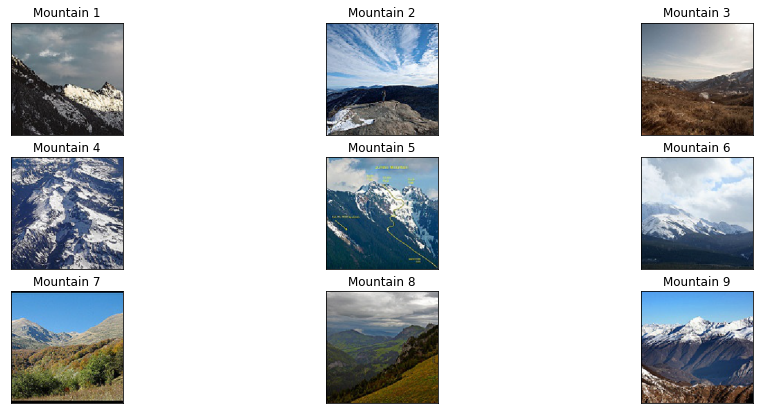

In [6]:
plt.figure(figsize=(16,7))

for image in range(0,9):
    plt.subplot(3,3, image +1)
    plt.imshow(images_raw[image])
    plt.title("Mountain {}".format(image+1))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

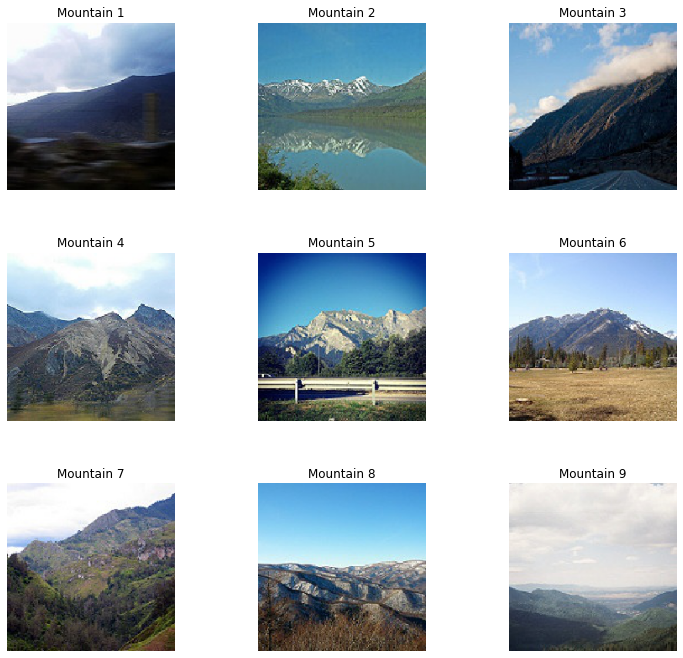

In [7]:
# random images 

fig, axs = plt.subplots(3, 3, figsize=(12,12))
axs=axs.ravel()

for image in range(0, 9):
    axs[image].imshow(random.choice(images_raw), cmap='gray')
    axs[image].set_title("Mountain {}".format(image+1))
    axs[image].axis('off')
plt.subplots_adjust(wspace=0.5)

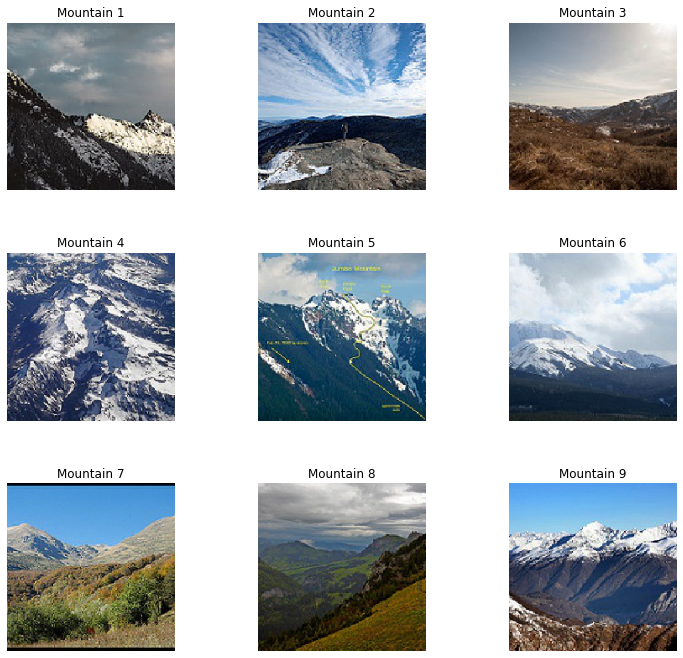

In [8]:
# sample images 

fig, axs = plt.subplots(3, 3, figsize=(12,12))
axs=axs.ravel()

for image in range(0, 9):
    axs[image].imshow(images_raw[image], cmap='gray')
    axs[image].set_title("Mountain {}".format(image+1))
    axs[image].axis('off')
plt.subplots_adjust(wspace=0.5)

In [9]:
# load images (already preprocessing images)

images_list = []
path = "/content/drive/My Drive/Deep Learning - Projetos/GANs/imagens"

for dir in os.listdir(path):
    image_path = os.path.join(path, dir)
    img = load_img(image_path, target_size=(200, 200, 3), color_mode="rgb")
    img = img_to_array(img)
    img /= 255.0
    images_list.append(img)

# array 4D images 
images = np.array(images_list)

In [10]:
len(images)

2334

In [11]:
BUFFER_SIZE = 195
BATCH_SIZE = 32

In [12]:
# dataset
train_data = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
# content image
for img in train_data:
  print(img)

A saída de streaming foi truncada nas últimas 5000 linhas.
   [0.         0.03529412 0.        ]
   ...
   [0.02352941 0.03137255 0.01176471]
   [0.02352941 0.03137255 0.01176471]
   [0.01960784 0.02745098 0.00784314]]

  [[0.09019608 0.12941177 0.02352941]
   [0.         0.03529412 0.        ]
   [0.         0.03529412 0.        ]
   ...
   [0.02352941 0.03137255 0.01176471]
   [0.02352941 0.03137255 0.01176471]
   [0.01960784 0.02745098 0.00784314]]

  [[0.13725491 0.18431373 0.10588235]
   [0.19607843 0.23137255 0.15686275]
   [0.19607843 0.23137255 0.15686275]
   ...
   [0.01960784 0.02745098 0.00784314]
   [0.01960784 0.02745098 0.00784314]
   [0.01960784 0.02745098 0.00784314]]]


 [[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1. 

<hr>
<br>


#### DCGAN - Deep Convolutional Generative Adversarial Network

<br>

Deep Convolutional GANs (DCGANs) introduced convolutions to the generator and discriminator networks.

However, this was not simply a matter of adding convolutional layers to the model, since training became even more unstable.

Several tricks had to be applied to make DCGANs useful:

Batch normalization was applied to both the generator and the discriminator network
Dropout is used as a regularization technique
The generator needed a way to upsample the random input vector to an output image. Transposing convolutional layers is employed here
LeakyRelu and TanH activations are used throughout both networks




<br>




<p align=center>
<img src="https://gluon.mxnet.io/_images/dcgan.png" width="70%"></p>






<br>
<hr>

In [14]:
# define hyperparameters 

epochs = 50 
batch_size = 32
latent_dim = 100
number_samples_generate = 16
image_shape = (200,200,3)

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((25, 25, 256)))
    assert model.output_shape == (None, 25, 25, 256) 

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 100, 100, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 200, 200, 3)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    return model

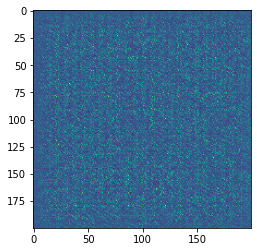

In [16]:
# Generate image 

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [17]:
# Discriminator 

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5, 5), strides=(2, 2), padding='same',
                                     input_shape=[200, 200, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100, 100, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        102464    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)      

In [19]:
# Discriminate image (positive values for true images  | negative values for false images)
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00010736]], shape=(1, 1), dtype=float32)


In [20]:
# loss function

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
# Loss both generator and discriminator (min-max)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss




In [22]:
# optmizer 

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
# checkpoint training 

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
seed = tf.random.normal([number_samples_generate, latent_dim])

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [27]:
# generate and save image 

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,6))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

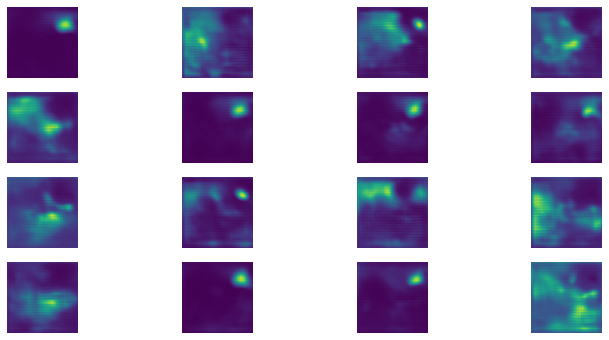

CPU times: user 9min 16s, sys: 4min 49s, total: 14min 6s
Wall time: 13min 51s


In [28]:
# train model (showing behind GAN model)

%%time 

train(train_data, epochs)